In [1]:
import libs
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from netCDF4 import Dataset
import time
import re

In [2]:
file_path = r"G:\0_postgraduate\DMSP\data\2011\16s1\dms_20110101_16s1.001.nc"
file = libs.File(file_path)
data = file.original_data
data['diff_b_hor'] = np.sqrt(data['diff_b_for']**2+data['diff_b_perp']**2)

In [3]:
class FFT:
    def __init__(self,data_v,v_str):
        """data_v类型为Series"""
        self.data_v = data_v
        self.v_str = v_str
        self.t = self.data_v.index.to_numpy()
        self.signal = self.data_v.values
        signal_fillna = self.data_v.fillna(method='ffill').fillna(method='bfill')
        self.signal_fillna = signal_fillna.values
        self.signal_fft = fft(self.signal_fillna)
        self.sample_freq = fftfreq(self.signal_fillna.size,d=self.t[1]-self.t[0])  # d为采样周期
        
    def bandpass_filter(self,epoch1,epoch2):
        # 选取不同频率段，创建一个带通滤波器
        bandpass_filter = (self.sample_freq > 1/epoch2) & (self.sample_freq < 1/epoch1)
        filtered_signal_fft = self.signal_fft.copy()
        filtered_signal_fft[~bandpass_filter] = 0
        # 进行傅里叶反变换，得到过滤后的信号
        filtered_signal = np.real(np.fft.ifft(filtered_signal_fft))
        return filtered_signal
    
    def draw(self,is_signal=False,is_freq_amp=False,is_bandpass_filter=False,figsize=(20,5),epoch1=None,epoch2=None):
        if is_signal:
            fig = plt.figure(figsize=figsize)
            plt.plot(self.t, self.signal)
            plt.title(self.v_str)
            return fig
        elif is_freq_amp:
            fig = plt.figure(figsize=figsize)
            plt.plot(self.sample_freq, np.abs(self.signal_fft))
            plt.title(f'Spectrogram after Fourier Transform of {self.v_str}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            return fig
        elif is_bandpass_filter:
            filtered_signal = self.bandpass_filter(epoch1,epoch2)
            fig = plt.figure(figsize=figsize)
            plt.plot(self.t, filtered_signal)
            plt.xlabel('Time (seconds)')
            plt.ylabel(self.v_str)
            return fig
        else:
            print("please choose one draw.")
            return 
        
        
def draw_bandpass_filter_2sides(data_v1,v1_str,data_v2,v2_str,epoch1,epoch2,figsize=(20,5)):
    v1_fft = FFT(data_v1,v1_str)
    v2_fft = FFT(data_v2,v2_str)
    t1 = v1_fft.t
    t2 = v2_fft.t
    if not np.array_equal(t1,t2):
        print("2个变量的index不同。")
        return
    t = t1
    filtered_signal1 = v1_fft.bandpass_filter(epoch1,epoch2)
    filtered_signal2 = v2_fft.bandpass_filter(epoch1,epoch2)
    fig,ax1 = plt.subplots(figsize=figsize)
    fig.suptitle(f"{v1_str} and {v2_str} after bandpass filter in range ({epoch1},{epoch2})")
    
    # 绘制第一组数据，使用左侧y轴
    color = 'tab:red'
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel(f'{v1_str}', color=color)
    ax1.plot(t, filtered_signal1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    # 创建第二个坐标轴，共享同一个x轴
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(f'{v2_str}', color=color)
    ax2.plot(t, filtered_signal2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    return fig   

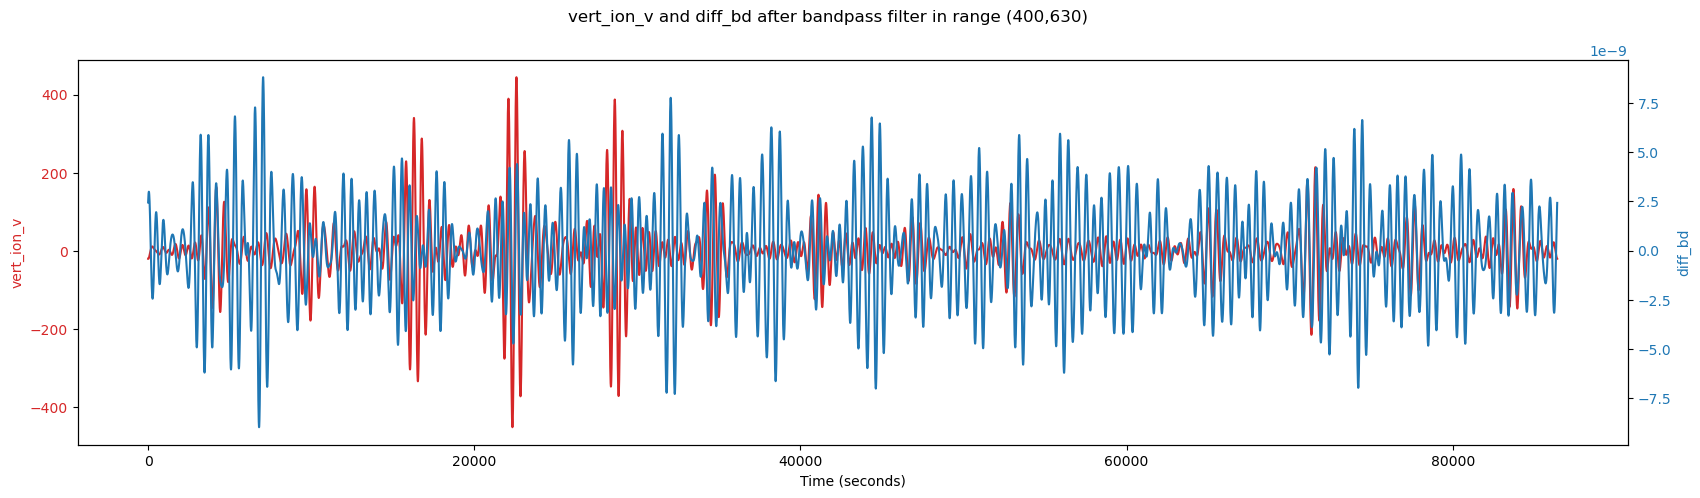

In [4]:
data_v1 = data['vert_ion_v']
data_v2 = data['diff_bd']
fig = draw_bandpass_filter_2sides(data_v1,'vert_ion_v',data_v2,'diff_bd',400,630)

In [5]:
# # 仅考虑正频率的部分
# positive_indices1 = sample_freq11 > 0
# positive_sample_freq1 = sample_freq11[positive_indices1]
# positive_signal_fft1 = signal_fft1[positive_indices1]
# 
# # 找到正频率中振幅最大的前100个点的索引
# indices = np.argsort(positive_signal_fft1)[-100:][::-1]
# 
# # 获取这些振幅对应的频率
# main_frequencies1 = positive_sample_freq1[indices]
# main_frequencies_sorted1 = np.sort(main_frequencies1)
# main_epochs1 = 1 / main_frequencies_sorted1
# 
# # 仅考虑正频率的部分
# positive_indices2 = sample_freq2 > 0
# positive_sample_freq2 = sample_freq2[positive_indices2]
# positive_signal_fft2 = signal_fft2[positive_indices2]
# 
# # 找到正频率中振幅最大的前100个点的索引
# indices = np.argsort(positive_signal_fft2)[-100:][::-1]
# 
# # 获取这些振幅对应的频率
# main_frequencies2 = positive_sample_freq2[indices]
# main_frequencies_sorted2 = np.sort(main_frequencies2)
# main_epochs2 = 2 / main_frequencies_sorted2